In [12]:
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random
import scanpy as sc
import numpy as np


def ST_preprocess(ST_exp, normalize=True, log=True, highly_variable_genes=True, n_top_genes=3000, pca=False,
                  n_comps=30):
    adata = ST_exp.copy()
    adata.var['mt'] = np.logical_or(adata.var_names.str.startswith('MT-'), adata.var_names.str.startswith('mt-'))
    adata.var['rb'] = adata.var_names.str.startswith(('RP', 'Rp', 'rp'))

    sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], inplace=True)
    mask_cell = adata.obs['pct_counts_mt'] < 100
    mask_gene = np.logical_and(~adata.var['mt'], ~adata.var['rb'])

    adata = adata[mask_cell, mask_gene]

    if highly_variable_genes:
        sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=n_top_genes)

    if normalize:
        sc.pp.normalize_total(adata, target_sum=1e4)

    if log:
        sc.pp.log1p(adata)

    if pca:
        sc.pp.pca(adata, n_comps=n_comps)
    return adata


def clr_normalize_each_cell(adata, inplace=True):
    """Normalize count vector for each cell, i.e. for each row of .X"""

    import numpy as np
    import scipy

    def seurat_clr(x):
        # TODO: support sparseness
        s = np.sum(np.log1p(x[x > 0]))
        exp = np.exp(s / len(x))
        return np.log1p(x / exp)

    if not inplace:
        adata = adata.copy()

    # apply to dense or sparse matrix, along axis. returns dense matrix
    adata.X = np.apply_along_axis(
        seurat_clr, 1, (adata.X.A if scipy.sparse.issparse(adata.X) else np.array(adata.X))
    )
    return adata


def generate_a_spot_poisson(adata_scrna, lam, max_cell_types_in_spot, library):
    cell_num = np.random.poisson(lam=lam) + 1
    cell_type_num = random.randint(1, max_cell_types_in_spot)
    cell_type_list_selected = np.random.choice(adata_scrna.obs['celltype'].value_counts().keys(), size=cell_type_num,
                                               replace=False)
    picked_cell_type = np.unique(np.random.choice(cell_type_list_selected, size=cell_num), return_counts=True)
    picked_cells = [np.random.choice(library[picked_cell_type[0][i]], picked_cell_type[1][i], replace=False) for i in
                    range(picked_cell_type[0].size)]
    picked_cells = [x for xs in picked_cells for x in xs]
    return adata_scrna[picked_cells]


def pse_srt_from_scrna(adata_scrna, spot_num=10000, lam=6, max_cell_types_in_spot=4):
    cell_types = adata_scrna.obs['celltype'].unique()
    word_to_idx_celltype = {word: i for i, word in enumerate(cell_types)}

    cell_type_num = len(cell_types)

    generated_spots = []
    library = {i: adata_scrna[adata_scrna.obs['celltype'] == i].obs_names for i in cell_types}
    for _ in tqdm(range(spot_num), desc='Generating pseudo-spots'):
        generated_spots.append(generate_a_spot_poisson(adata_scrna, lam, max_cell_types_in_spot, library))

    pse_srt_table = np.zeros((spot_num, adata_scrna.shape[1]), dtype=float)
    pse_fraction_table = np.zeros((spot_num, cell_type_num), dtype=float)
    for i in range(spot_num):
        one_spot = generated_spots[i]
        pse_srt_table[i] = one_spot.X.sum(axis=0)
        for j in one_spot.obs.index:
            cell_type = one_spot.obs.loc[j, 'celltype']
            type_idx = word_to_idx_celltype[cell_type]
            pse_fraction_table[i, type_idx] += 1
    pse_srt_table = pd.DataFrame(pse_srt_table, columns=adata_scrna.var.index.values)
    adata_pse_srt = sc.AnnData(X=pse_srt_table.values)
    adata_pse_srt.obs.index = pse_srt_table.index
    adata_pse_srt.var.index = pse_srt_table.columns
    pse_fraction_table = pd.DataFrame(pse_fraction_table, columns=cell_types)
    pse_fraction_table['cell_num'] = pse_fraction_table.sum(axis=1)
    for i in pse_fraction_table.columns[:-1]:
        pse_fraction_table[i] = pse_fraction_table[i] / pse_fraction_table['cell_num']
    adata_pse_srt.obs = adata_pse_srt.obs.join(pse_fraction_table)
    return adata_pse_srt


dataname = 'human_lymph_node'
adata_omics1 = sc.read_h5ad('Dataset/' + dataname + '/adata_RNA.h5ad')
adata_omics1.var_names_make_unique()
sc.pp.filter_genes(adata_omics1, min_cells=1)

# preprocss ST data
adata_scrna = sc.read_h5ad('Dataset/' + dataname + '/adata_scrna.h5ad')
common_genes = [g for g in adata_omics1.var_names if g in adata_scrna.var_names]
adata_omics1 = adata_omics1[:, common_genes]
adata_omics1 = ST_preprocess(adata_omics1, n_top_genes=3000, n_comps=50)
adata_omics1 = adata_omics1[:, adata_omics1.var.highly_variable]

adata_scrna.obs['celltype'] = adata_scrna.obs['Subset']

/opt/anaconda3/envs/test/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/opt/anaconda3/envs/test/lib/python3.11/site-packages/scanpy/preprocessing/_highly_variable_genes.py:163: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [26]:
lam = 2
max_cell_types_in_spot = 4
adata_pse_omics1 = pse_srt_from_scrna(adata_scrna[:, adata_omics1.var_names], spot_num=adata_omics1.n_obs, lam=lam,
                                      max_cell_types_in_spot=max_cell_types_in_spot)
# preprocess pseudo spots
adata_pse_omics1 = ST_preprocess(adata_pse_omics1, highly_variable_genes=False, n_comps=50)
adata_pse_omics1.obs = adata_pse_omics1.obs.iloc[:, :adata_scrna.obs['Subset'].nunique()]

Generating pseudo-spots: 100%|██████████| 3484/3484 [00:23<00:00, 145.83it/s]
/opt/anaconda3/envs/test/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/opt/anaconda3/envs/test/lib/python3.11/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


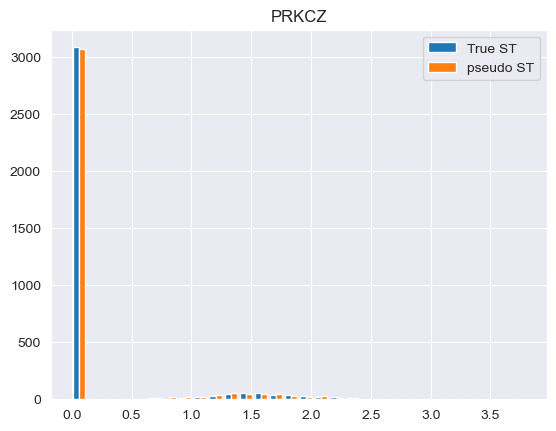

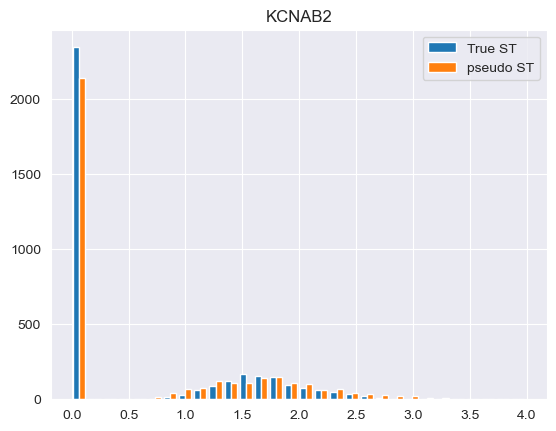

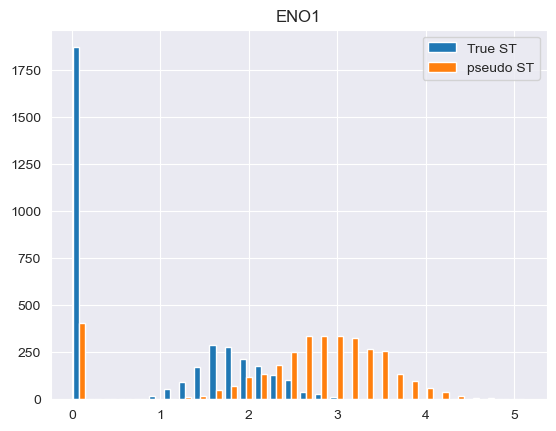

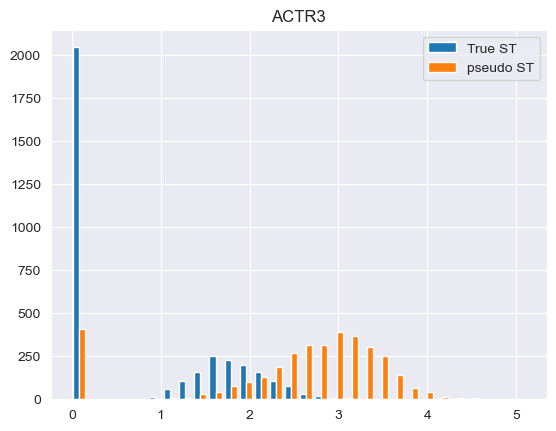

In [47]:

for var_id in [7, 9, 15, 400]:
    plt.hist([adata_omics1[:, adata_omics1.var_names[var_id]].X.toarray()[:, 0], adata_pse_omics1[:, adata_omics1.var_names[var_id]].X.toarray()[:, 0]], bins=30, label=['True ST', 'pseudo ST'])
    plt.title(adata_omics1.var_names[var_id])
    plt.legend()
    plt.savefig('preliminary_results/' + str(var_id) + '.pdf')
    plt.show()

In [48]:
result_scrna = pd.read_csv('results/test_scrna.csv')
result_wrtscrna = pd.read_csv('results/test_wrtscrna.csv')

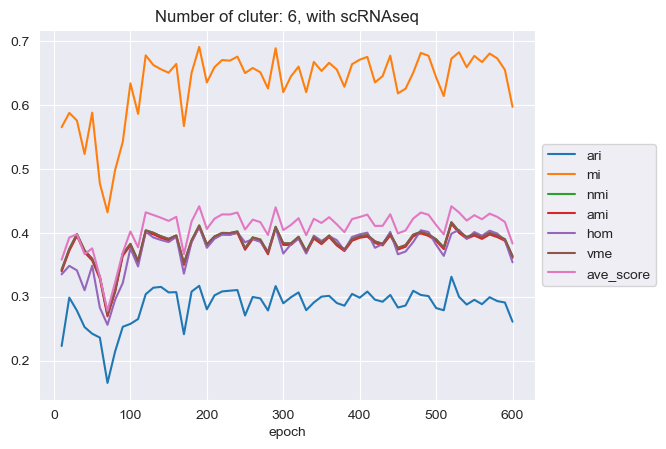

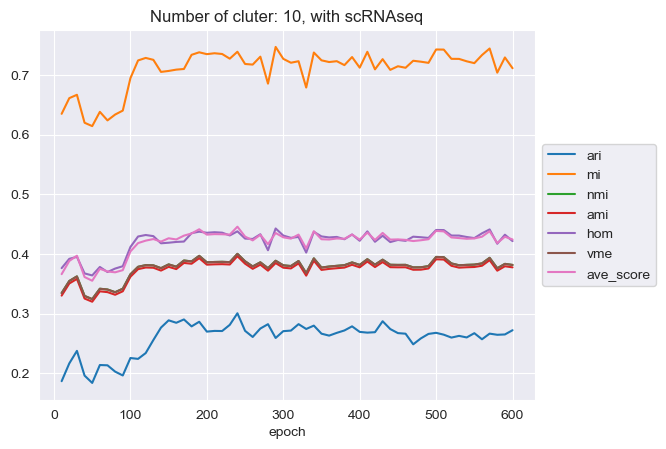

In [67]:
result_scrna_6 = result_scrna[result_scrna['n_cluster'] == 6]
for metrics in ['ari', 'mi', 'nmi', 'ami', 'hom', 'vme', 'ave_score']:
    plt.plot(result_scrna_6['epoch'], result_scrna_6[metrics], label=metrics)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Number of cluter: 6, with scRNAseq")
plt.xlabel("epoch")
plt.savefig('preliminary_results/test_scrna_6.pdf', bbox_inches='tight')
plt.show()
result_scrna_10 = result_scrna[result_scrna['n_cluster'] == 10]
for metrics in ['ari', 'mi', 'nmi', 'ami', 'hom', 'vme', 'ave_score']:
    plt.plot(result_scrna_10['epoch'], result_scrna_10[metrics], label=metrics)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Number of cluter: 10, with scRNAseq")
plt.xlabel("epoch")
plt.savefig('preliminary_results/test_scrna_10.pdf', bbox_inches='tight')
plt.show()

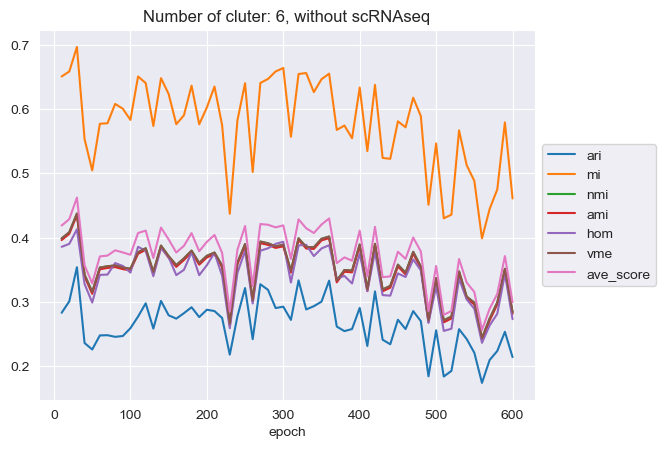

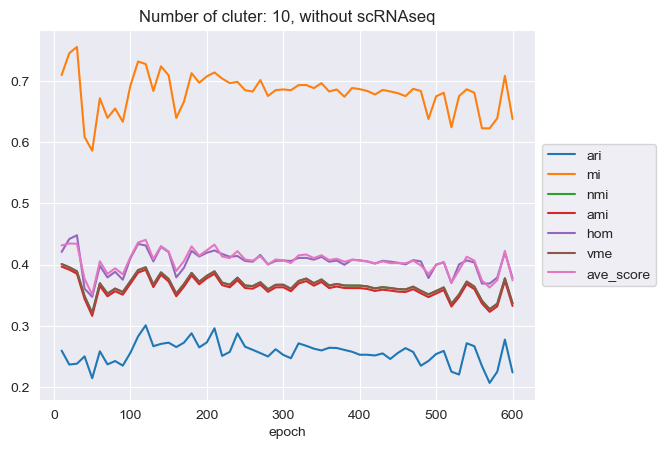

In [66]:
result_wrtscrna_6 = result_wrtscrna[result_wrtscrna['n_cluster'] == 6]
for metrics in ['ari', 'mi', 'nmi', 'ami', 'hom', 'vme', 'ave_score']:
    plt.plot(result_wrtscrna_6['epoch'], result_wrtscrna_6[metrics], label=metrics)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Number of cluter: 6, without scRNAseq")
plt.xlabel("epoch")
plt.savefig('preliminary_results/test_wrtscrna_6.pdf', bbox_inches='tight')
plt.show()
result_wrtscrna_10 = result_wrtscrna[result_wrtscrna['n_cluster'] == 10]
for metrics in ['ari', 'mi', 'nmi', 'ami', 'hom', 'vme', 'ave_score']:
    plt.plot(result_wrtscrna_10['epoch'], result_wrtscrna_10[metrics], label=metrics)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Number of cluter: 10, without scRNAseq")
plt.xlabel("epoch")
plt.savefig('preliminary_results/test_wrtscrna_10.pdf', bbox_inches='tight')
plt.show()